In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
tf.random.set_seed(42)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
#sklearn imports
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
# from sklearn. import 
# from sklearn. import 

In [3]:
#Function declaration
def analyze(df):
    print(df.info(), df.describe(), "\n")
    
def find_mismatches(df, col, y):
    print(df[col].value_counts())
    print(np.where(df[col].astype('bool') != y))
    print(df.iloc[np.where(df[col].astype('bool') != y)].shape)
    print()
    
def score_model(model, X_train, X_valid, y_train, y_valid):
    model.fit(X_train, y_train)
    y_predt = model.predict(X_train)
    y_predv = model.predict(X_valid)
    print("train accuracy:", accuracy_score(y_train, y_predt))
    print("valid accuracy:", accuracy_score(y_valid, y_predv))
    print("train f1:", f1_score(y_train, y_predt))
    print("valid f1:", f1_score(y_valid, y_predv))
    print()
    
def tune_hyperparameter(search, X, y):
    search.fit(X, y)
    print("best f1:", search.best_score_)
    print("best params:", search.best_params_)
    
def plot_loss(history, valid=True):
    plt.plot(history.history['loss'])
    if valid:
        plt.plot(history.history['val_loss'])
        plt.legend(["loss", "val_loss"])
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [4]:
#Data preparation
X = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
y = X.pop('target')
X_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

to_drop = ['id', 'location']
X.drop(to_drop, inplace=True, axis=1)

print(X.shape, y.shape, "\n")
analyze(X)
y.value_counts()

(7613, 2) (7613,) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  7552 non-null   object
 1   text     7613 non-null   object
dtypes: object(2)
memory usage: 119.1+ KB
None            keyword                                               text
count         7552                                               7613
unique         221                                               7503
top     fatalities  11-Year-Old Boy Charged With Manslaughter of T...
freq            45                                                 10 



target
0    4342
1    3271
Name: count, dtype: int64

In [5]:
#Feature engineering
disasters = ["landslide", "landslides", "avalanche", "avalanches", "earthquake", "earthquakes", 
             "sinkhole", "sinkholes", "hole", "holes", "volcano", "volcanoes", "eruption", 
             "eruptions", "flood", "floods", "flooding", "tsunami", "heat", "drought", 
             "droughts", "dust", "fire", "fires", "wildfire", "wildfires", "cyclone", 
             "thunderstorm", "thunderstorms", "thunder", "tornado", "tornadoes", "blizzard", 
             "blizzards", "hailstorm", "hailstorms", "hail", "hails", "storm", "storms", "kill", 
             "kills", "bomb", "bombs", "attack", "attacks", "suicide", "suicides", "gas", 
             "gases", "oil", "crash", "crashes"]
responses = ["rescue", "rescues", "water", "emergency", "emergencies", "prevention", 
             "preventions", "disease", "diseases", "repair", "repairs", "service", "services", 
             "transport", "shelter", "shelters", "rebuilding", "home", "homes", "hospital", 
             "hospitals", "road", "roads", "building", "buildings", "avoid", "situation", 
             "situations", "serious", "evacuate", "evacuation", "evacuations", "debris", 
             "damage", "damages", "lost"]

count_dict = dict.fromkeys(disasters+responses, 0)
tp_dict = dict.fromkeys(disasters+responses, 0)
for i in range(X.shape[0]):
    sentence = X.text[i].split()
#     print(sentence)
    for word in sentence:
        word = word.strip("#:.'").lower()
        if word in count_dict:
            count_dict[word] += 1
            if y[i] == 1:
                tp_dict[word] += 1
word_mapping = {word: tp_dict[word] / count_dict[word] if count_dict[word] else 0 for word in count_dict}
# print(count_dict)
# print(tp_dict)
print(word_mapping, "\n")

def engineer(df):
    df_ = df.drop('text', axis=1)
    df_['disaster'] = df.text.apply(lambda x: sum(word_mapping[s.strip("#:.'").lower()] for s in x.split() if s.strip("#:.'").lower() in disasters))
    df_['response'] = df.text.apply(lambda x: sum(word_mapping[s.strip("#:.'").lower()] for s in x.split() if s.strip("#:.'").lower() in responses))
    return df_
    
X_eng = engineer(X)
# print(X_eng.head(10))
# np.set_printoptions(threshold=None)
# find_mismatches(X_eng, 'disaster', y)
# find_mismatches(X_eng, 'response', y)
# np.set_printoptions(threshold=np.inf)
# print(X_eng.iloc[np.where((X_eng['disaster'].astype('bool') != y) & (X_eng['response'].astype('bool') != y))])
print(X_eng.iloc[np.where((X_eng['disaster'].astype('bool') != y) & (X_eng['response'].astype('bool') != y))].shape[0])
print()
    
# print(X_eng.shape, "\n")
# analyze(X_eng)

{'landslide': 0.5714285714285714, 'landslides': 1.0, 'avalanche': 0.2, 'avalanches': 0, 'earthquake': 0.8979591836734694, 'earthquakes': 0.6666666666666666, 'sinkhole': 0.7027027027027027, 'sinkholes': 0, 'hole': 0.2, 'holes': 1.0, 'volcano': 0.7666666666666667, 'volcanoes': 1.0, 'eruption': 1.0, 'eruptions': 0, 'flood': 0.6727272727272727, 'floods': 0.7321428571428571, 'flooding': 0.74, 'tsunami': 0.42857142857142855, 'heat': 0.6888888888888889, 'drought': 0.8378378378378378, 'droughts': 1.0, 'dust': 0.6486486486486487, 'fire': 0.7183673469387755, 'fires': 0.8421052631578947, 'wildfire': 0.96875, 'wildfires': 1.0, 'cyclone': 0.6896551724137931, 'thunderstorm': 0.8297872340425532, 'thunderstorms': 0.8888888888888888, 'thunder': 0.46511627906976744, 'tornado': 0.7241379310344828, 'tornadoes': 0.6, 'blizzard': 0.11764705882352941, 'blizzards': 0, 'hailstorm': 0.85, 'hailstorms': 0, 'hail': 0.6111111111111112, 'hails': 0, 'storm': 0.7256637168141593, 'storms': 0.8333333333333334, 'kill': 

In [6]:
#Feature transformation
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="none"), 
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=len(X_eng.keyword.unique()))
)
ct = ColumnTransformer([
    ('cat', cat_pipeline, make_column_selector(dtype_include=object))
], remainder='passthrough')

ct.fit(X_eng)
X_trans = pd.DataFrame(ct.transform(X_eng), columns=ct.get_feature_names_out())

# print(X_trans.shape, "\n")
# analyze(X_trans)

In [7]:
#Train/Valid sets preparation
X_train, X_valid, y_train, y_valid = train_test_split(X_trans, y, stratify=y, random_state=42)

print(X_train.shape, X_valid.shape)
print(y_train.value_counts(), y_valid.value_counts())

(5709, 3) (1904, 3)
target
0    3256
1    2453
Name: count, dtype: int64 target
0    1086
1     818
Name: count, dtype: int64


In [8]:
#Model selection
dtc = DecisionTreeClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42, max_features=None)
# abc = AdaBoostClassifier(random_state=42)
# gbc = GradientBoostingClassifier(random_state=42)
# svc = SVC(random_state=42, C=100)

score_model(dtc, X_train, X_valid, y_train, y_valid)
score_model(rfc, X_train, X_valid, y_train, y_valid)
# score_model(abc, X_train, X_valid, y_train, y_valid)
# score_model(gbc, X_train, X_valid, y_train, y_valid)
# score_model(svc, X_train, X_valid, y_train, y_valid)

train accuracy: 0.789805570152391
valid accuracy: 0.7426470588235294
train f1: 0.740484429065744
valid f1: 0.6842783505154639

train accuracy: 0.789805570152391
valid accuracy: 0.7442226890756303
train f1: 0.7448979591836735
valid f1: 0.6911857958148382



In [9]:
# print(dtc.get_depth())
# print([estimator.tree_.max_depth for estimator in rfc.estimators_])
# print(max([estimator.tree_.max_depth for estimator in rfc.estimators_]))

In [10]:
#Hyperparameter tuning
params1 = {'max_depth': [10, 20, 25, None], 'min_samples_split': [4, 6, 7, 8, 9, 10]}
params2 = {'max_depth': [10, 15, 20, 25, 30], 'min_samples_split': [2, 3, 4, 5], 'n_estimators': [8, 10, 25, 50]}

gs_dtc = GridSearchCV(dtc, params1, scoring='f1')
gs_rfc = GridSearchCV(rfc, params2, scoring='f1', cv=3)

tune_hyperparameter(gs_dtc, X_trans, y)
tune_hyperparameter(gs_rfc, X_trans, y)

best f1: 0.3635857486012281
best params: {'max_depth': None, 'min_samples_split': 8}
best f1: 0.39633262211194104
best params: {'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 25}


In [11]:
dtc.set_params(**gs_dtc.best_params_)
rfc.set_params(**gs_rfc.best_params_)
score_model(gs_dtc, X_train, X_valid, y_train, y_valid)
score_model(gs_rfc, X_train, X_valid, y_train, y_valid)

train accuracy: 0.7826239271325977
valid accuracy: 0.7400210084033614
train f1: 0.7312107429066493
valid f1: 0.6796116504854369

train accuracy: 0.7880539499036608
valid accuracy: 0.7447478991596639
train f1: 0.7446179822710005
valid f1: 0.6935687263556117



In [12]:
#Test set preparation
X_test_eng = engineer(X_test.drop(to_drop, axis=1))
X_test_trans = pd.DataFrame(ct.transform(X_test_eng), columns=ct.get_feature_names_out())

print(X_test_trans.shape, "\n")
analyze(X_test_trans)

(3263, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cat__keyword         3263 non-null   float64
 1   remainder__disaster  3263 non-null   float64
 2   remainder__response  3263 non-null   float64
dtypes: float64(3)
memory usage: 76.6 KB
None        cat__keyword  remainder__disaster  remainder__response
count   3263.000000          3263.000000          3263.000000
mean     110.074471             0.187488             0.077130
std       64.245155             0.409938             0.247763
min        0.000000             0.000000             0.000000
25%       54.000000             0.000000             0.000000
50%      111.000000             0.000000             0.000000
75%      166.500000             0.000000             0.000000
max      221.000000             4.271858             2.100823 



In [13]:
#Final prediction
dtc.fit(X_trans, y)
rfc.fit(X_trans, y)
print(dtc.score(X_trans, y), rfc.score(X_trans, y))

submission = pd.DataFrame({'id': X_test.id, 'target': rfc.predict(X_test_trans)})
submission.to_csv('submission.csv', index=False)
pd.read_csv('/kaggle/working/submission.csv')

0.782608695652174 0.7801129646657035


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,0
3261,10874,0


In [14]:
#Prepare tf dataset
X_train, X_valid, y_train, y_valid = train_test_split(X.text, y, stratify=y, random_state=42, test_size=0.2)

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(1)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(32).prefetch(1)

for x in train_set.take(1):
    print(x)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Sassy city girl country hunk stranded in Smoky Mountain snowstorm #AoMS http://t.co/nkKcTttsD9 #ibooklove #bookboost',
       b"God's Kingdom (Heavenly Gov't) will rule over all people on the earth after Armageddon.  http://t.co/8HGcBXUkz0  http://t.co/4kopkCyvTt",
       b'Mopheme and Bigstar Johnson are a problem in this game body bagging niggas #VuzuHustle',
       b'@VixMeldrew sounds like a whirlwind life!',
       b'Malaysia confirms plane debris washed up on Reunion Island is from Flight MH370 http://t.co/YS3WALzvjg',
       b'Live a balanced life! Balance your fear of #Allah with hope in His mercy and love for Him.',
       b'CLIMATE CONSEQUENCES: U.S. Forest Service Says Spending More Than Half Of Budget On Fires http://t.co/k0QtL8aODH http://t.co/zQBXe7x9Y7',
       b'brooke just face timed me at the concert and just screamed for 2 minutes straight',
       b"'But time began at last to obliterate the freshness of my alar

In [15]:
#Text vectorization
text_vect_layer = tf.keras.layers.TextVectorization(ragged=True)
# text_vect_layer.adapt(tf.data.Dataset.from_tensor_slices(X_train))
text_vect_layer.adapt(tf.data.Dataset.from_tensor_slices(X.text))
print(text_vect_layer.vocabulary_size())

22699


In [16]:
#Build model
embedding_size = 64

model = tf.keras.Sequential([
    text_vect_layer, 
    tf.keras.layers.Embedding(text_vect_layer.vocabulary_size(), embedding_size,), 
    tf.keras.layers.GRU(64, return_sequences=True), 
    tf.keras.layers.GRU(64),
#     tf.keras.layers.BatchNormalization(), 
#     tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/100
191/191 [==============================] - 30s 120ms/step - loss: 0.5261 - accuracy: 0.7379 - val_loss: 0.4355 - val_accuracy: 0.8043
Epoch 2/100
191/191 [==============================] - 2s 11ms/step - loss: 0.2431 - accuracy: 0.9057 - val_loss: 0.5078 - val_accuracy: 0.7853
Epoch 3/100
191/191 [==============================] - 2s 11ms/step - loss: 0.1049 - accuracy: 0.9606 - val_loss: 0.6544 - val_accuracy: 0.7708
Epoch 4/100
191/191 [==============================] - 2s 11ms/step - loss: 0.0524 - accuracy: 0.9844 - val_loss: 0.7049 - val_accuracy: 0.7754
Epoch 5/100
191/191 [==============================] - 2s 11ms/step - loss: 0.0339 - accuracy: 0.9923 - val_loss: 0.7030 - val_accuracy: 0.7682
Epoch 6/100
191/191 [==============================] - 2s 11ms/step - loss: 0.0270 - accuracy: 0.9929 - val_loss: 0.6809 - val_accuracy: 0.7597
Epoch 7/100
191/191 [==============================] - 2s 11ms/step - loss: 0.0265 - accuracy: 0.9939 - val_loss: 0.7253 - val_accurac

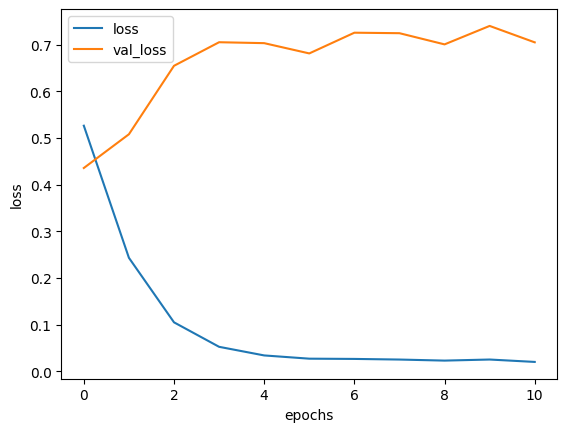

In [17]:
#Fit model
es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_set, validation_data=valid_set, epochs=100, callbacks=[es])

plot_loss(history)

In [18]:
history2 = model.fit(train_set.concatenate(valid_set), epochs=1)

# plot_loss(history2, valid=False)

239/239 [==============================] - 4s 16ms/step - loss: 0.3170 - accuracy: 0.8654


In [19]:
#Final prediction 2
predictions = map(lambda x: 1 if x > 0.5 else 0, model.predict(X_test.text))

submission2 = pd.DataFrame({'id': X_test.id, 'target': predictions})
submission2.to_csv('submission2.csv', index=False)
pd.read_csv('/kaggle/working/submission2.csv')

102/102 [==============================] - 1s 4ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1
